# Import Data

In [1]:
# helper.py
from helper import *

In [2]:
# load data
df = pd.read_csv('./data/clean/features.csv')

# check
df.shape, len(set(df.player))

((1099, 310), 237)

- Over 1000 QB seasons for training and validation.
- 306 features (excluding player name, team, year, and target).
- 227 unique QBs.

# Optimize XGBoost

In [3]:
# non-feature cols
non_feat_cols = ['player', 'team_name', 'year', 'target']

# define X and y
X = df.drop(columns=non_feat_cols)
y = df['target']

In [4]:
# define the parameter search space
param_bounds = {
    'max_depth': (1, 10),
    'learning_rate': (0.001, 0.1),
    'gamma': (0, 1),
    'min_child_weight': (1, 10),
    'subsample': (0.5, 1.0),
    'colsample_bytree': (0.5, 1.0)
}

# run bayesian optimization
optimizer = BayesianOptimization(f=lambda max_depth, learning_rate, gamma, min_child_weight, subsample, colsample_bytree: 
            xgb_cv(max_depth, learning_rate, gamma, min_child_weight, subsample, colsample_bytree, X, y),
            pbounds=param_bounds,
            random_state=SEED,
            verbose=2)

# optimize for 110 iterations
optimizer.maximize(init_points=10, n_iter=100)

|   iter    |  target   | colsam... |   gamma   | learni... | max_depth | min_ch... | subsample |
-------------------------------------------------------------------------------------------------
| 1         | -12.22    | 0.5052    | 0.5019    | 0.05008   | 2.204     | 2.279     | 0.6093    |
| 2         | -12.68    | 0.7093    | 0.2481    | 0.009322  | 4.109     | 2.501     | 0.9393    |
| 3         | -12.63    | 0.9755    | 0.03875   | 0.07021   | 6.155     | 9.082     | 0.8334    |
| 4         | -12.5     | 0.7739    | 0.7024    | 0.03926   | 7.25      | 8.424     | 0.7328    |
| 5         | -12.55    | 0.9703    | 0.8037    | 0.09835   | 2.527     | 5.69      | 0.9728    |
| 6         | -12.49    | 0.8248    | 0.8608    | 0.09711   | 2.67      | 3.188     | 0.9367    |
| 7         | -12.45    | 0.9531    | 0.7583    | 0.03534   | 5.172     | 6.495     | 0.7481    |
| 8         | -12.39    | 0.739     | 0.4356    | 0.08717   | 2.686     | 7.189     | 0.8518    |
| 9         | -12.61

In [4]:
# get best parameters
best_params = {'colsample_bytree': 0.5051870769428499,
 'gamma': 0.5018745921487388,
 'learning_rate': 0.050081556020280464,
 'max_depth': 2,
 'min_child_weight': 2,
 'subsample': 0.6092793378130391, 
 'n_estimators': 100}

# define model
xgb = XGBRegressor(**best_params, random_state=SEED, n_jobs=-1)

# 2024 Predictions
Here we will train on the 2006-2022 data and then use the 2023 data as the holdout test set to predict the 2024 grades.

In [5]:
# define training data (before 2023) and test data (2023)
X_train = df.query('year < 2023').drop(columns=non_feat_cols)
y_train = df.query('year < 2023')['target']
X_test = df.query('year == 2023').drop(columns=non_feat_cols)
y_test = df.query('year == 2023')['target']

# train model
xgb.fit(X_train, y_train)

# make predictions
y_pred = xgb.predict(X_test)

# evaluate model
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)
print(f'RMSE: {rmse:.4f}')
print(f'R2: {r2:.4f}')

RMSE: 11.4856
R2: 0.3566


- The best model resulted with a RMSE of 11.49 and a r2 0.36 when predicting on the holdout set (2024).

In [6]:
# create a df for our predictions
preds_df = pd.DataFrame(data={'player': df.query('year == 2023')['player'].values, 'team': df.query('year == 2023')['team_name'].values, 
                              'y_true': y_test, 'y_pred': y_pred, 'error': (y_pred - y_test)})

# map colors to our preds_df
preds_df['color'] = preds_df['team'].map(TEAM_COLORS)

# percent of preds within 10 pts
percent = (preds_df.error.abs() < 10).sum() / len(preds_df)
print(f'{percent*100:.1f}% of our model\'s predictions are within 10 pts of the true value.')

63.3% of our model's predictions are within 10 pts of the true value.


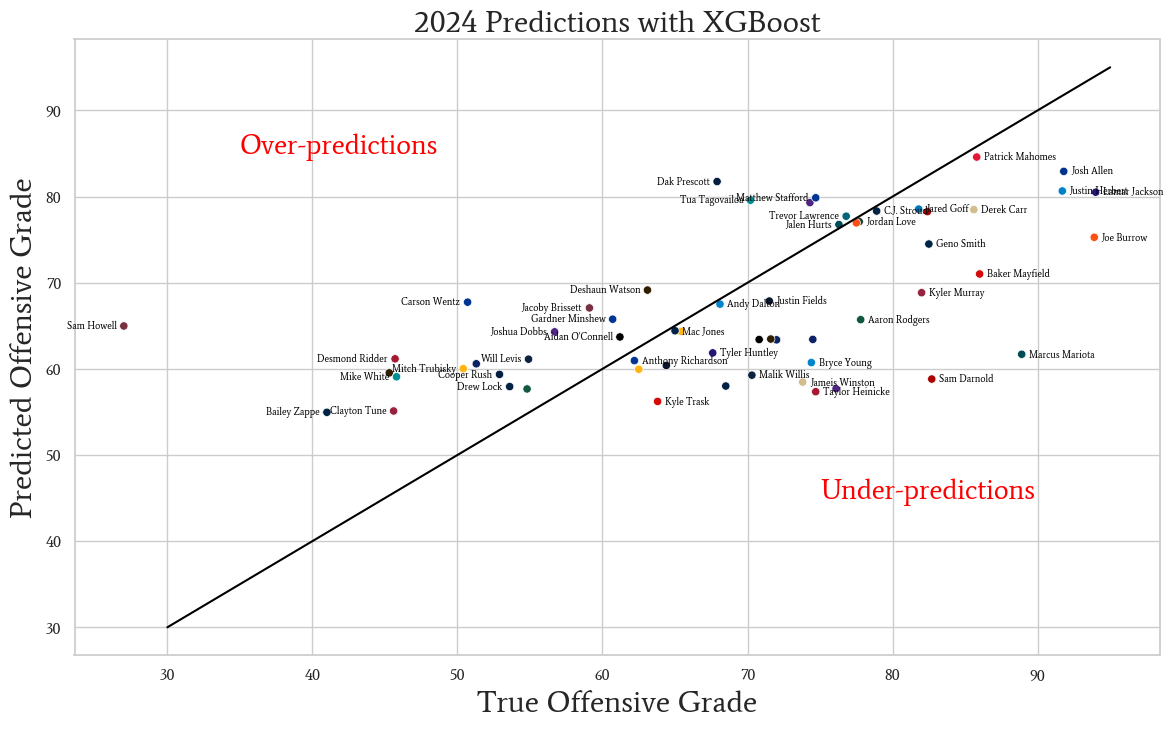

In [8]:
# plot 2024 predictions
plot_2024_preds(preds_df)

- Each point represents a single player in 2024.
- The distance from the black line is how far off our prediction was. Ideally, a perfect model would only have dots on the line. 
- Dots above the line are cases in which our model overpredictions, and dots below the line are underpredictions.

# 2025 Predictions

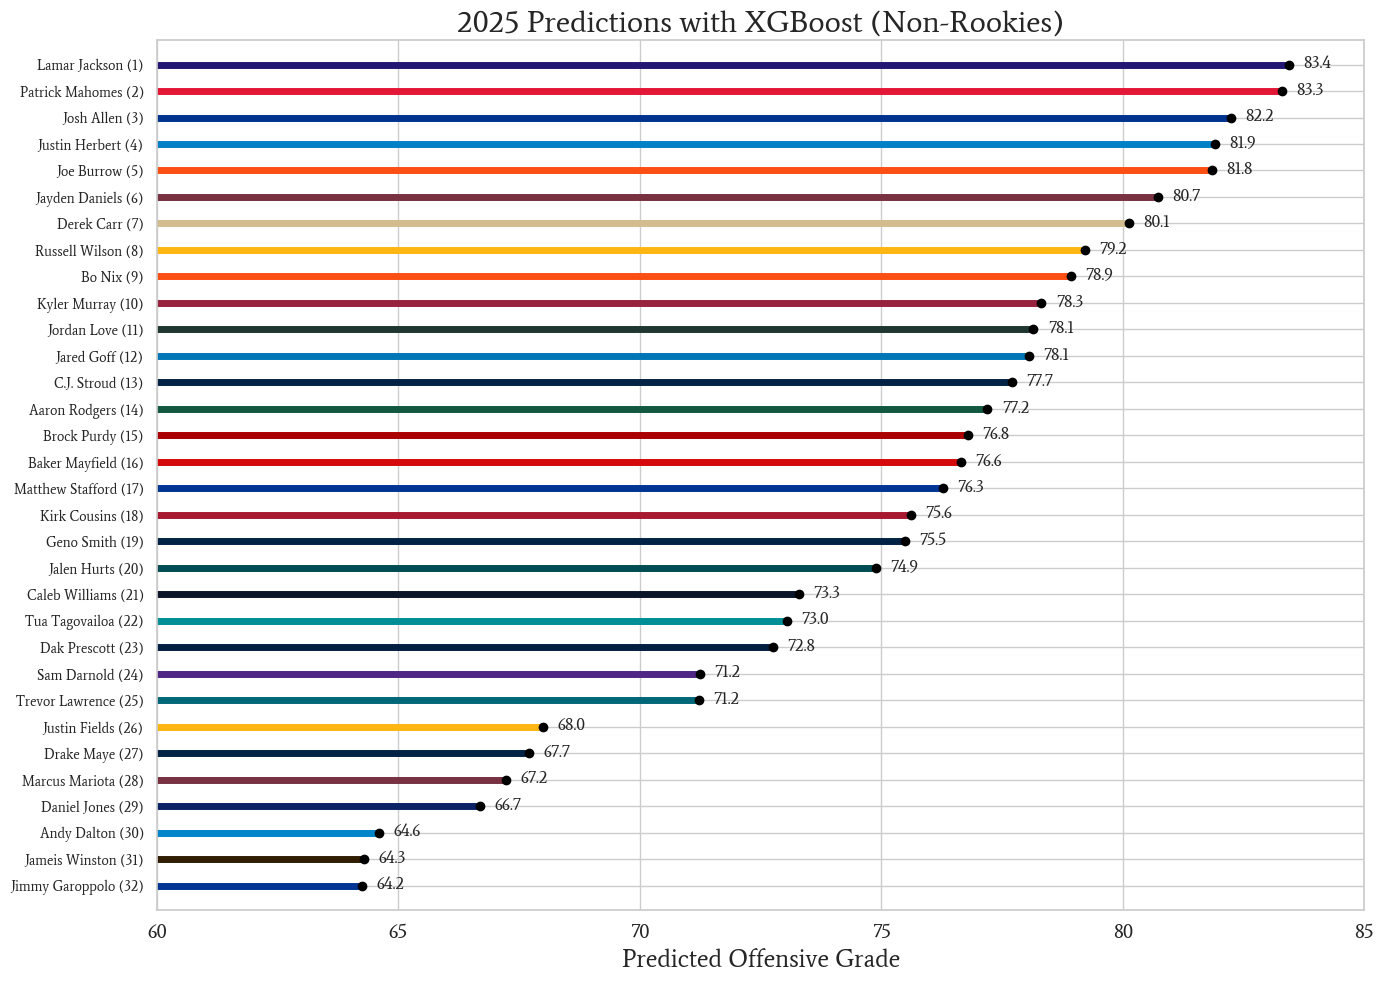

In [35]:
# load 2024 data
df_2024 = pd.read_csv('./data/clean/features_2024.csv')

# fit model on all data
xgb.fit(X, y)

# make predictions on 2024 data
y_pred_2024 = xgb.predict(df_2024.drop(columns=non_feat_cols))

# create a df for our preds and sort
preds_2024_df = pd.DataFrame(data={'player': df_2024['player'].values, 'team': df_2024['team_name'].values, 'y_pred': y_pred_2024}).sort_values('y_pred', ascending=False).reset_index(drop=True)

# map colors
preds_2024_df['color'] = preds_2024_df['team'].map(TEAM_COLORS)

# get top 32
top_32 = preds_2024_df.head(32).copy()

# add rank
top_32['player_with_rank'] = [f'{name} ({i+1})' for i, name in enumerate(top_32['player'])]

# plot 2025 predictions
plot_2025_preds(top_32)